# IT549: Deep Learning – Lab 2
## GloVe Pretrained Embeddings for Movie Text Prediction

## Step 0: Install Dependencies


In [1]:
# Install required libraries
!pip install kaggle torch scikit-learn pandas numpy matplotlib seaborn nltk tqdm

# Download NLTK resources (for tokenization and lemmatization)
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
print("All dependencies installed!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


All dependencies installed!


In [ ]:
import os
import pandas as pd

DATA_PATH = '/content/'

csv_files = [f for f in os.listdir(DATA_PATH) if f.endswith('.csv')]
print("CSV files found:", csv_files)

if not csv_files:
    print("No CSV found in /content/")
else:
    df = pd.read_csv(os.path.join(DATA_PATH, csv_files[0]))
    print(f"Loaded: {csv_files[0]}")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

CSV files found: ['movie_dataset.csv']
✅ Loaded: movie_dataset.csv
   Shape: (4803, 24)
   Columns: ['index', 'budget', 'genres', 'homepage', 'id', 'keywords', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'vote_average', 'vote_count', 'cast', 'crew', 'director']


---
## Step 2: Download GloVe Embeddings

**What:** GloVe 6B vectors (trained on 6 billion tokens from Wikipedia + Gigaword).  
**Why 100D:** Good balance between semantic richness and computational cost.  
We use the **100-dimensional** version.

In [ ]:
import urllib.request
import zipfile
# ── GloVe: Point to your local file ──────────────────────────────────────────
GLOVE_FILE = '/content/wiki_giga_2024_100_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05.050_combined.txt'  # ← Change this path to where your GloVe file is

GLOVE_DIM = 100  # Change to 200 if you have the 200d version

# Verify the file exists
import os
if os.path.exists(GLOVE_FILE):
    print(f"✅ GloVe file found: {GLOVE_FILE}")
    print(f"   Dimension: {GLOVE_DIM}D")
else:
    print(f"❌ File not found at: {GLOVE_FILE}")
    print("   Please update GLOVE_FILE path to point to your local glove file.")

✅ GloVe file found: /content/wiki_giga_2024_100_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05.050_combined.txt
   Dimension: 100D


## Task 1: Data Preparation

In [7]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# ── 1.1 Load Dataset ─────────────────────────────────────────────────────────
# Find the CSV file (adjust filename as needed)
csv_files = [f for f in os.listdir(DATA_PATH) if f.endswith('.csv')]
print("CSV files found:", csv_files)

df = pd.read_csv(os.path.join(DATA_PATH, csv_files[0]))
print(f"\nOriginal dataset shape: {df.shape}")
print("Columns available:", df.columns.tolist())

CSV files found: ['movie_dataset.csv']

Original dataset shape: (4803, 24)
Columns available: ['index', 'budget', 'genres', 'homepage', 'id', 'keywords', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'vote_average', 'vote_count', 'cast', 'crew', 'director']


In [ ]:
REQUIRED_COLS = ['genre', 'keywords', 'tagline', 'overview', 'vote_average']

# Handle common column name variations
col_map = {}
for col in df.columns:
    cl = col.lower().strip()
    if 'vote' in cl and 'average' in cl:
        col_map[col] = 'voting_average'
    elif cl in ['genre', 'genres']:
        col_map[col] = 'genre'
    elif cl in ['keyword', 'keywords']:
        col_map[col] = 'keywords'
    elif cl == 'tagline':
        col_map[col] = 'tagline'
    elif cl == 'overview':
        col_map[col] = 'overview'

df = df.rename(columns=col_map)
available = [c for c in ['genre', 'keywords', 'tagline', 'overview', 'voting_average'] if c in df.columns]
df = df[available].copy()
print(f"Retained columns: {df.columns.tolist()}")
print(f"Dataset shape after filtering: {df.shape}")
df.head(3)

Retained columns: ['genre', 'keywords', 'tagline', 'overview', 'voting_average']
Dataset shape after filtering: (4803, 5)


,genre,keywords,tagline,overview,voting_average
0,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,Enter the World of Pandora.,"In the 22nd century, a paraplegic Marine is di...",7.2
1,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,"At the end of the world, the adventure begins.","Captain Barbossa, long believed to be dead, ha...",6.9
2,Action Adventure Crime,spy based on novel secret agent sequel mi6,A Plan No One Escapes,A cryptic message from Bond’s past sends him o...,6.3


In [ ]:
print("Missing values per column:")
print(df.isnull().sum())

print("\nvoting_average stats:")
print(df['voting_average'].describe())

# Fill NaN text with empty string
for col in ['keywords', 'tagline', 'overview']:
    if col in df.columns:
        df[col] = df[col].fillna('')

# Drop rows with missing targets
df = df.dropna(subset=['voting_average', 'genre'])
df = df[df['genre'].str.strip() != '']
print(f"\nShape after dropping rows with missing targets: {df.shape}")

Missing values per column:
genre              28
keywords          412
tagline           844
overview            4
voting_average      0
dtype: int64

voting_average stats:
count    4803.000000
mean        6.092172
std         1.194612
min         0.000000
25%         5.600000
50%         6.200000
75%         6.800000
max        10.000000
Name: voting_average, dtype: float64

Shape after dropping rows with missing targets: (4775, 5)


In [ ]:
import ast

def parse_genres(genre_val):
    """Normalize genre column to a list of genre strings."""
    if pd.isnull(genre_val) or genre_val == '':
        return []
    s = str(genre_val).strip()
    # Handle pipe-separated: "Action|Drama"
    if '|' in s:
        return [g.strip() for g in s.split('|') if g.strip()]
    # Handle list-like string: "['Action', 'Drama']"
    if s.startswith('['):
        try:
            parsed = ast.literal_eval(s)
            if isinstance(parsed, list):
                return [str(g).strip() for g in parsed if str(g).strip()]
        except:
            pass
    # Handle comma-separated
    if ',' in s:
        return [g.strip().strip("'\"") for g in s.split(',') if g.strip()]
    # Single genre
    return [s]

df['genre_list'] = df['genre'].apply(parse_genres)

# Get all unique genres
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(df['genre_list'])
ALL_GENRES = list(mlb.classes_)

print(f"Total unique genres found: {len(ALL_GENRES)}")
print("Genres:", ALL_GENRES)

# Add binary columns for each genre
genre_df = pd.DataFrame(genre_matrix, columns=ALL_GENRES, index=df.index)
df = pd.concat([df, genre_df], axis=1)

print("\nGenre frequency distribution:")
genre_counts = genre_df.sum().sort_values(ascending=False)
print(genre_counts.head(15))

Total unique genres found: 1168
Genres: ['Action', 'Action Adventure', 'Action Adventure Animation Comedy Family', 'Action Adventure Animation Comedy Science Fiction', 'Action Adventure Animation Family', 'Action Adventure Animation Family Fantasy', 'Action Adventure Animation Fantasy Science Fiction', 'Action Adventure Animation Science Fiction Thriller', 'Action Adventure Comedy', 'Action Adventure Comedy Crime', 'Action Adventure Comedy Crime Drama', 'Action Adventure Comedy Crime Mystery', 'Action Adventure Comedy Crime Romance', 'Action Adventure Comedy Crime Thriller', 'Action Adventure Comedy Drama Family', 'Action Adventure Comedy Drama Foreign', 'Action Adventure Comedy Drama Mystery', 'Action Adventure Comedy Drama Science Fiction', 'Action Adventure Comedy Family', 'Action Adventure Comedy Family Fantasy', 'Action Adventure Comedy Family Science Fiction', 'Action Adventure Comedy Fantasy', 'Action Adventure Comedy Fantasy Science Fiction', 'Action Adventure Comedy Romance', 

In [ ]:
STOP_WORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, lemmatize=True):
    """
    Full text preprocessing pipeline:
    1. Lowercase              → GloVe vectors are lowercase
    2. Remove URLs            → Not semantically useful
    3. Remove numbers         → Movie metadata numbers (years, budgets) aren't useful
    4. Remove punctuation     → Only letters matter for word embeddings
    5. Tokenize               → Split into individual words
    6. Remove stopwords       → 'the', 'is', 'a' carry no meaning
    7. Lemmatize (optional)   → Reduce to base form
    """
    if not isinstance(text, str) or text.strip() == '':
        return []
    # Step 1: Lowercase
    text = text.lower()
    # Step 2: Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Step 3: Remove numbers
    text = re.sub(r'\d+', '', text)
    # Step 4: Remove punctuation (keep only letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    # Step 5: Tokenize
    tokens = word_tokenize(text)
    # Step 6: Remove stopwords and very short tokens
    tokens = [t for t in tokens if t not in STOP_WORDS and len(t) > 2]
    # Step 7: Lemmatize
    if lemmatize:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

# Apply preprocessing to all text columns
for col in ['overview', 'tagline', 'keywords']:
    if col in df.columns:
        df[f'{col}_tokens'] = df[col].apply(preprocess_text)
        print(f"Preprocessed '{col}' — example: {df[f'{col}_tokens'].iloc[0][:10]}")

Preprocessed 'overview' — example: ['century', 'paraplegic', 'marine', 'dispatched', 'moon', 'pandora', 'unique', 'mission', 'becomes', 'torn']
Preprocessed 'tagline' — example: ['enter', 'world', 'pandora']
Preprocessed 'keywords' — example: ['culture', 'clash', 'future', 'space', 'war', 'space', 'colony', 'society']


In [ ]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42  

df['rating_bin'] = pd.cut(df['voting_average'], bins=5, labels=False)

train_df, temp_df = train_test_split(
    df, test_size=0.30, random_state=RANDOM_STATE, stratify=df['rating_bin']
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=RANDOM_STATE, stratify=temp_df['rating_bin']
)

print(f"Train size:      {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation size: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test size:       {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

Train size:      3342 (70.0%)
Validation size: 716 (15.0%)
Test size:       717 (15.0%)


## Task 2: GloVe Embedding Pipeline

In [ ]:
from tqdm import tqdm

print(f"Loading GloVe {GLOVE_DIM}D vectors...")
glove_vectors = {}
skipped = 0

with open(GLOVE_FILE, 'r', encoding='utf-8') as f:
    for line in tqdm(f, desc="Loading GloVe"):
        parts = line.strip().split()
        if len(parts) < GLOVE_DIM + 1:
            skipped += 1
            continue
        word = parts[0]
        try:
            vec = np.array(parts[1:GLOVE_DIM + 1], dtype=np.float32)
            if len(vec) == GLOVE_DIM:
                glove_vectors[word] = vec
        except ValueError:
            skipped += 1
            continue

print(f"\n✅ Total GloVe vocabulary size: {len(glove_vectors):,} words")
print(f"   Skipped malformed lines: {skipped}")
print(f"   Vector shape: {list(glove_vectors.values())[0].shape}")

Loading GloVe 100D vectors...


Loading GloVe: 775741it [00:36, 21403.12it/s]



✅ Total GloVe vocabulary size: 773,841 words
   Skipped malformed lines: 1887
   Vector shape: (100,)


In [ ]:
def compute_coverage(token_series, glove_vocab):
    all_tokens = set()
    for tokens in token_series:
        all_tokens.update(tokens)
    covered = {t for t in all_tokens if t in glove_vocab}
    coverage = len(covered) / len(all_tokens) * 100 if all_tokens else 0
    return len(all_tokens), len(covered), coverage

print("=" * 55)
print(f"{'Column':<12} {'Total Tokens':>14} {'Covered':>9} {'Coverage':>10}")
print("=" * 55)
for col in ['overview', 'tagline', 'keywords']:
    if f'{col}_tokens' in df.columns:
        total, covered, pct = compute_coverage(df[f'{col}_tokens'], glove_vectors)
        print(f"{col:<12} {total:>14,} {covered:>9,} {pct:>9.1f}%")
print("=" * 55)
print("\nHigher coverage = better semantic representation")

Column         Total Tokens   Covered   Coverage
overview             20,258    18,223      90.0%
tagline               3,592     3,426      95.4%
keywords              4,177     4,048      96.9%

Higher coverage = better semantic representation


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tokens_to_string(tokens):
    """Join token list back into a string for TF-IDF."""
    return ' '.join(tokens) if tokens else ''

def build_tfidf_glove_embeddings(train_tokens, all_tokens_list, glove_vecs, dim=100):
    """
    Build TF-IDF weighted GloVe document embeddings.

    Args:
        train_tokens: list of token lists from TRAINING set only (to avoid data leakage)
        all_tokens_list: list of token lists for ALL splits
        glove_vecs: GloVe dictionary
        dim: embedding dimension

    Returns:
        embeddings: numpy array of shape (n_docs, dim)
        tfidf: fitted TfidfVectorizer
    """

    train_strings = [tokens_to_string(t) for t in train_tokens]
    tfidf = TfidfVectorizer()
    tfidf.fit(train_strings)

    vocab = tfidf.vocabulary_   
    idf = tfidf.idf_            

    embeddings = []
    for tokens in all_tokens_list:
        if not tokens:
            embeddings.append(np.zeros(dim, dtype=np.float32))
            continue

        weighted_sum = np.zeros(dim, dtype=np.float32)
        weight_total = 0.0

        from collections import Counter
        tf = Counter(tokens)
        doc_len = len(tokens)

        for word, count in tf.items():
            if word in glove_vecs and word in vocab:
                tf_score = count / doc_len              
                idf_score = idf[vocab[word]]            
                weight = tf_score * idf_score           
                weighted_sum += weight * glove_vecs[word]
                weight_total += weight

        if weight_total > 0:
            embeddings.append(weighted_sum / weight_total)
        else:
            embeddings.append(np.zeros(dim, dtype=np.float32))

    return np.array(embeddings), tfidf

print("Embedding pipeline built.")
print("We will call build_tfidf_glove_embeddings() separately for each text column.")

Embedding pipeline built.
We will call build_tfidf_glove_embeddings() separately for each text column.


In [ ]:
TEXT_COLS = [c for c in ['overview', 'tagline', 'keywords'] if f'{c}_tokens' in df.columns]
embeddings_dict = {}  

for col in TEXT_COLS:
    print(f"\nBuilding TF-IDF GloVe embeddings for: {col}")
    train_tokens = train_df[f'{col}_tokens'].tolist()
    val_tokens   = val_df[f'{col}_tokens'].tolist()
    test_tokens  = test_df[f'{col}_tokens'].tolist()

    all_tokens = train_tokens + val_tokens + test_tokens
    all_embs, tfidf = build_tfidf_glove_embeddings(train_tokens, all_tokens, glove_vectors, GLOVE_DIM)

    n_train = len(train_tokens)
    n_val   = len(val_tokens)

    embeddings_dict[col] = {
        'train': all_embs[:n_train],
        'val':   all_embs[n_train:n_train+n_val],
        'test':  all_embs[n_train+n_val:],
        'tfidf': tfidf
    }
    print(f"  Train: {embeddings_dict[col]['train'].shape}")
    print(f"  Val:   {embeddings_dict[col]['val'].shape}")
    print(f"  Test:  {embeddings_dict[col]['test'].shape}")


Building TF-IDF GloVe embeddings for: overview
  Train: (3342, 100)
  Val:   (716, 100)
  Test:  (717, 100)

Building TF-IDF GloVe embeddings for: tagline
  Train: (3342, 100)
  Val:   (716, 100)
  Test:  (717, 100)

Building TF-IDF GloVe embeddings for: keywords
  Train: (3342, 100)
  Val:   (716, 100)
  Test:  (717, 100)


## Task 3: Model A – Rating Prediction (Regression)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

class RegressionMLP(nn.Module):
    """
    Multi-layer perceptron for regression.

    Architecture:
    Input(100) → Linear(256) → ReLU → Dropout(0.3) → Linear(128) → ReLU → Dropout(0.3) → Linear(1)

    Why:
    - Two hidden layers: enough capacity to learn non-linear patterns
    - ReLU: fast, avoids vanishing gradient
    - Dropout: prevents overfitting to training set
    - No output activation: free to predict any real value (rating can be any float)
    """
    def __init__(self, input_dim=100, hidden1=256, hidden2=128, dropout=0.3):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2, 1)
        )

    def forward(self, x):
        return self.network(x).squeeze(-1)

print("Regression MLP defined.")
model_test = RegressionMLP(GLOVE_DIM)
print(model_test)

Using device: cpu
Regression MLP defined.
RegressionMLP(
  (network): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [ ]:
def train_regression_model(X_train, y_train, X_val, y_val,
                            input_dim=100, epochs=100, lr=1e-3, batch_size=64):
    """
    Train the regression MLP.

    Loss: MSELoss — directly minimizes mean squared error
    Optimizer: Adam — adaptive learning rates, generally converges faster than SGD
    Early stopping: saves best model based on validation loss
    """

    X_tr = torch.FloatTensor(X_train).to(DEVICE)
    y_tr = torch.FloatTensor(y_train).to(DEVICE)
    X_vl = torch.FloatTensor(X_val).to(DEVICE)
    y_vl = torch.FloatTensor(y_val).to(DEVICE)

    dataset = TensorDataset(X_tr, y_tr)
    loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = RegressionMLP(input_dim).to(DEVICE)
    criterion = nn.MSELoss()          
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

    best_val_loss = float('inf')
    best_weights  = None
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            pred = model(X_batch)
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * len(X_batch)

        train_loss = epoch_loss / len(X_train)

        model.eval()
        with torch.no_grad():
            val_pred = model(X_vl)
            val_loss = criterion(val_pred, y_vl).item()

        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights  = {k: v.clone() for k, v in model.state_dict().items()}

        if (epoch + 1) % 20 == 0:
            print(f"  Epoch {epoch+1:3d}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    model.load_state_dict(best_weights)
    return model, train_losses, val_losses

def evaluate_regression(model, X_test, y_test):
    """Compute MSE and RMSE on test set."""
    model.eval()
    X_t = torch.FloatTensor(X_test).to(DEVICE)
    with torch.no_grad():
        preds = model(X_t).cpu().numpy()

    mse  = np.mean((preds - y_test) ** 2)
    rmse = np.sqrt(mse)
    return mse, rmse, preds

print("Training functions defined.")

Training functions defined.


In [ ]:
y_train = train_df['voting_average'].values
y_val   = val_df['voting_average'].values
y_test  = test_df['voting_average'].values

baseline_pred = np.full_like(y_test, fill_value=y_train.mean())
baseline_mse  = np.mean((baseline_pred - y_test) ** 2)
baseline_rmse = np.sqrt(baseline_mse)

print("=" * 40)
print(f"Global Mean Rating (train): {y_train.mean():.4f}")
print(f"Baseline MSE:  {baseline_mse:.4f}")
print(f"Baseline RMSE: {baseline_rmse:.4f}")
print("=" * 40)
print("↑ This is the bar our neural model must beat")

Global Mean Rating (train): 6.1081
Baseline MSE:  1.2322
Baseline RMSE: 1.1101
↑ This is the bar our neural model must beat


In [ ]:
regression_results = {}

for col in TEXT_COLS[:4]:  
    print(f"\n{'='*50}")
    print(f"Training Regression Model: Input = '{col}'")
    print('='*50)

    X_train = embeddings_dict[col]['train']
    X_val   = embeddings_dict[col]['val']
    X_test  = embeddings_dict[col]['test']

    model, train_losses, val_losses = train_regression_model(
        X_train, y_train, X_val, y_val,
        input_dim=GLOVE_DIM, epochs=100, lr=1e-3, batch_size=64
    )

    mse, rmse, preds = evaluate_regression(model, X_test, y_test)

    print(f"\n→ Test MSE:  {mse:.4f}")
    print(f"→ Test RMSE: {rmse:.4f}")

    regression_results[col] = {
        'model': model, 'train_losses': train_losses, 'val_losses': val_losses,
        'mse': mse, 'rmse': rmse, 'preds': preds
    }


Training Regression Model: Input = 'overview'
  Epoch  20/100 | Train Loss: 1.4367 | Val Loss: 1.4528
  Epoch  40/100 | Train Loss: 1.3055 | Val Loss: 1.4980
  Epoch  60/100 | Train Loss: 1.1803 | Val Loss: 1.5144
  Epoch  80/100 | Train Loss: 1.1435 | Val Loss: 1.5236
  Epoch 100/100 | Train Loss: 1.1570 | Val Loss: 1.5240

→ Test MSE:  1.2739
→ Test RMSE: 1.1287

Training Regression Model: Input = 'tagline'
  Epoch  20/100 | Train Loss: 1.4900 | Val Loss: 1.4203
  Epoch  40/100 | Train Loss: 1.2503 | Val Loss: 1.4884
  Epoch  60/100 | Train Loss: 1.1754 | Val Loss: 1.4985
  Epoch  80/100 | Train Loss: 1.1345 | Val Loss: 1.4962
  Epoch 100/100 | Train Loss: 1.1664 | Val Loss: 1.4941

→ Test MSE:  1.3337
→ Test RMSE: 1.1549

Training Regression Model: Input = 'keywords'
  Epoch  20/100 | Train Loss: 1.4537 | Val Loss: 1.3296
  Epoch  40/100 | Train Loss: 1.2845 | Val Loss: 1.2759
  Epoch  60/100 | Train Loss: 1.1541 | Val Loss: 1.2879
  Epoch  80/100 | Train Loss: 1.1349 | Val Loss: 1

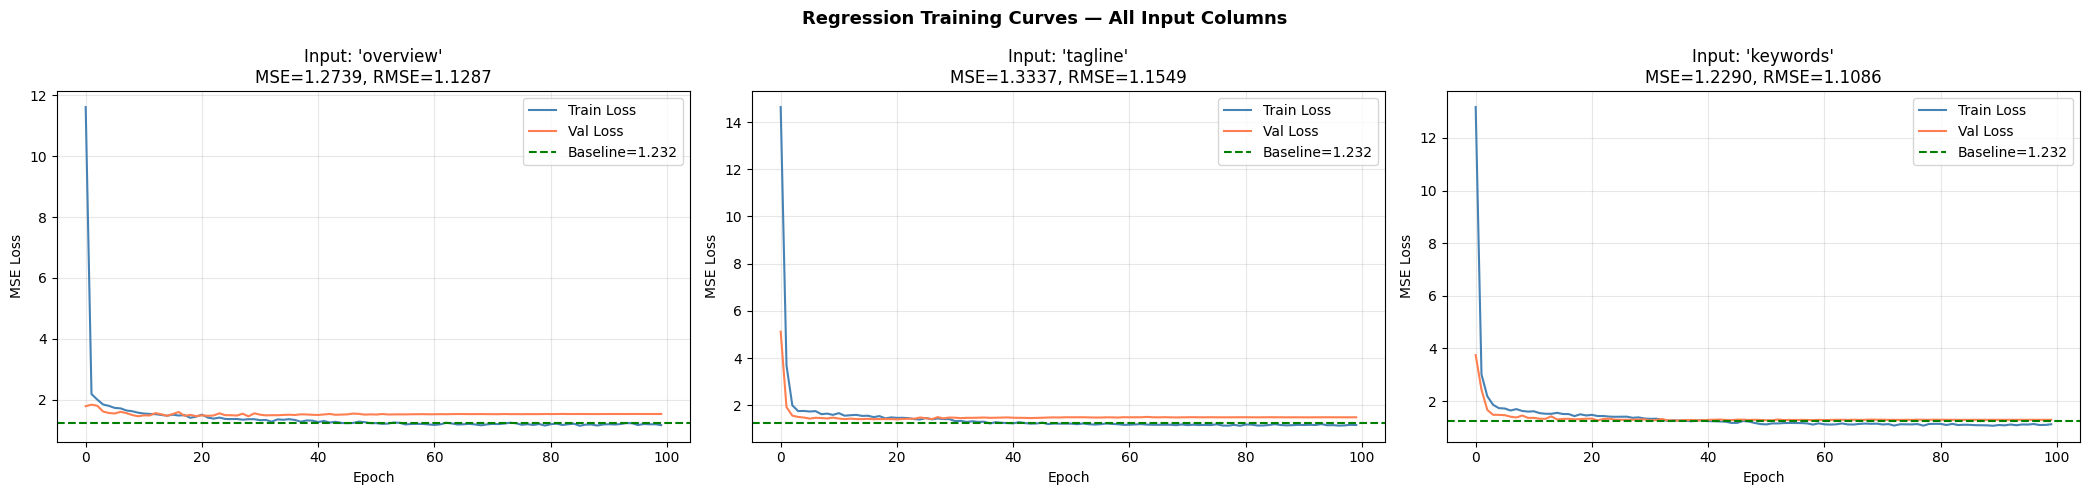


Column              MSE       RMSE
Baseline         1.2322     1.1101
overview         1.2739     1.1287
tagline          1.3337     1.1549
keywords         1.2290     1.1086


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(regression_results), figsize=(7*len(regression_results), 5))
if len(regression_results) == 1:
    axes = [axes]

for ax, (col, res) in zip(axes, regression_results.items()):
    ax.plot(res['train_losses'], label='Train Loss', color='steelblue')
    ax.plot(res['val_losses'],   label='Val Loss',   color='coral')
    ax.axhline(baseline_mse, color='green', linestyle='--', label=f'Baseline={baseline_mse:.3f}')
    ax.set_title(f"Input: '{col}'\nMSE={res['mse']:.4f}, RMSE={res['rmse']:.4f}")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Regression Training Curves — All Input Columns', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('./regression_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 45)
print(f"{'Column':<12} {'MSE':>10} {'RMSE':>10}")
print("=" * 45)
print(f"{'Baseline':<12} {baseline_mse:>10.4f} {baseline_rmse:>10.4f}")
for col, res in regression_results.items():
    print(f"{col:<12} {res['mse']:>10.4f} {res['rmse']:>10.4f}")
print("=" * 45)

## Task 4: Model B – Genre Prediction (Multi-Label Classification)

In [ ]:
class MultiLabelMLP(nn.Module):
    """
    Multi-label classifier.

    Key difference from regression:
    - Output dimension = number of genres
    - NO sigmoid here (BCEWithLogitsLoss does it internally for numerical stability)
    - At inference: apply sigmoid and threshold at 0.5
    """
    def __init__(self, input_dim=100, hidden1=256, hidden2=128, num_classes=20, dropout=0.5):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2, num_classes)  
        )

    def forward(self, x):
        return self.network(x) 

NUM_GENRES = len(ALL_GENRES)
print(f"Number of genres (output neurons): {NUM_GENRES}")
print("Genres:", ALL_GENRES)

Number of genres (output neurons): 1168
Genres: ['Action', 'Action Adventure', 'Action Adventure Animation Comedy Family', 'Action Adventure Animation Comedy Science Fiction', 'Action Adventure Animation Family', 'Action Adventure Animation Family Fantasy', 'Action Adventure Animation Fantasy Science Fiction', 'Action Adventure Animation Science Fiction Thriller', 'Action Adventure Comedy', 'Action Adventure Comedy Crime', 'Action Adventure Comedy Crime Drama', 'Action Adventure Comedy Crime Mystery', 'Action Adventure Comedy Crime Romance', 'Action Adventure Comedy Crime Thriller', 'Action Adventure Comedy Drama Family', 'Action Adventure Comedy Drama Foreign', 'Action Adventure Comedy Drama Mystery', 'Action Adventure Comedy Drama Science Fiction', 'Action Adventure Comedy Family', 'Action Adventure Comedy Family Fantasy', 'Action Adventure Comedy Family Science Fiction', 'Action Adventure Comedy Fantasy', 'Action Adventure Comedy Fantasy Science Fiction', 'Action Adventure Comedy Ro

In [ ]:
print(genre_counts)
print(f"\nRarest genre:  {genre_counts.index[0]} → {genre_counts.iloc[0]} movies")
print(f"Common genre:  {genre_counts.index[-1]} → {genre_counts.iloc[-1]} movies")

rare_genres = genre_counts[genre_counts < 10].index.tolist()
print(f"\nRare genres to consider dropping: {rare_genres}")

TV Movie              5.0
Foreign              24.0
Western              56.0
Documentary          82.0
War                 101.0
Music               129.0
History             140.0
Animation           165.0
Mystery             250.0
Fantasy             285.0
Family              351.0
Horror              358.0
Science Fiction     377.0
Crime               481.0
Adventure           544.0
Romance             646.0
Action              821.0
Thriller            882.0
Comedy             1214.0
Drama              1591.0
dtype: float32

Rarest genre:  TV Movie → 5.0 movies
Common genre:  Drama → 1591.0 movies

Rare genres to consider dropping: ['TV Movie']


In [62]:
from sklearn.preprocessing import MultiLabelBinarizer

CORE_GENRES = [
    'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign',
    'History', 'Horror', 'Music', 'Mystery', 'Romance',
    'Science Fiction', 'Thriller', 'TV Movie', 'War', 'Western'
]

def parse_genres_correct(genre_val):
    if pd.isnull(genre_val) or str(genre_val).strip() == '':
        return []
    s = str(genre_val).strip()
    found = [g for g in CORE_GENRES if g.lower() in s.lower()]
    return found if found else [s]

df['genre_list'] = df['genre'].apply(parse_genres_correct)

mlb = MultiLabelBinarizer(classes=CORE_GENRES)
genre_matrix = mlb.fit_transform(df['genre_list'])
ALL_GENRES = list(mlb.classes_)

df = df.drop(columns=[c for c in df.columns if c in ALL_GENRES], errors='ignore')
genre_df = pd.DataFrame(genre_matrix, columns=ALL_GENRES, index=df.index)
df = pd.concat([df, genre_df], axis=1)

print(f"Number of genres: {len(ALL_GENRES)}")
print("Genres:", ALL_GENRES)
print("\nGenre distribution:")
print(genre_df.sum().sort_values(ascending=False))

Number of genres: 20
Genres: ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'Thriller', 'TV Movie', 'War', 'Western']

Genre distribution:
Drama              2297
Comedy             1722
Thriller           1259
Action             1153
Romance             890
Adventure           790
Crime               696
Science Fiction     530
Horror              519
Family              510
Fantasy             418
Mystery             347
Animation           234
History             197
Music               183
War                 142
Documentary         110
Western              80
Foreign              34
TV Movie              8
dtype: int64


In [63]:
from sklearn.model_selection import train_test_split

df['rating_bin'] = pd.cut(df['voting_average'], bins=5, labels=False)

train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42, stratify=df['rating_bin'])
val_df,  test_df  = train_test_split(temp_df, test_size=0.50, random_state=42, stratify=temp_df['rating_bin'])

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 3342 | Val: 716 | Test: 717


In [64]:
y_genre_train = train_df[ALL_GENRES].values.astype(np.float32)
y_genre_val   = val_df[ALL_GENRES].values.astype(np.float32)
y_genre_test  = test_df[ALL_GENRES].values.astype(np.float32)

print(f"Train: {y_genre_train.shape} | Val: {y_genre_val.shape} | Test: {y_genre_test.shape}")
print(f"Avg genres per movie: {y_genre_train.sum(axis=1).mean():.2f}")

genre_counts = pd.DataFrame(y_genre_train, columns=ALL_GENRES).sum().sort_values()
print("\nGenre counts in training set:")
print(genre_counts)
print(f"\nRarest genre: {genre_counts.index[0]} → {int(genre_counts.iloc[0])} movies")
print(f"Common genre: {genre_counts.index[-1]} → {int(genre_counts.iloc[-1])} movies")

rare_genres = genre_counts[genre_counts < 10].index.tolist()
print(f"\nRare genres (< 10 samples): {rare_genres}")

Train: (3342, 20) | Val: (716, 20) | Test: (717, 20)
Avg genres per movie: 2.54

Genre counts in training set:
TV Movie              5.0
Foreign              24.0
Western              56.0
Documentary          82.0
War                 101.0
Music               129.0
History             140.0
Animation           165.0
Mystery             250.0
Fantasy             285.0
Family              351.0
Horror              358.0
Science Fiction     377.0
Crime               481.0
Adventure           544.0
Romance             646.0
Action              821.0
Thriller            882.0
Comedy             1214.0
Drama              1591.0
dtype: float32

Rarest genre: TV Movie → 5 movies
Common genre: Drama → 1591 movies

Rare genres (< 10 samples): ['TV Movie']


In [ ]:
from sklearn.metrics import f1_score, hamming_loss, jaccard_score

def train_classification_model(X_train, y_train, X_val, y_val,
                                input_dim=100, num_classes=20,
                                epochs=100, lr=1e-3, batch_size=64):
    X_tr = torch.FloatTensor(X_train).to(DEVICE)
    y_tr = torch.FloatTensor(y_train).to(DEVICE)
    X_vl = torch.FloatTensor(X_val).to(DEVICE)
    y_vl = torch.FloatTensor(y_val).to(DEVICE)

    dataset = TensorDataset(X_tr, y_tr)
    loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = MultiLabelMLP(input_dim, num_classes=num_classes).to(DEVICE)

    pos_weight = torch.tensor(
        (y_train.shape[0] - y_train.sum(0)) / (y_train.sum(0) + 1e-8),
        dtype=torch.float32
    ).to(DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

    best_val_loss = float('inf')
    best_weights  = None
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            logits = model(X_batch)
            loss   = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * len(X_batch)

        train_loss = epoch_loss / len(X_train)

        model.eval()
        with torch.no_grad():
            val_logits = model(X_vl)
            val_loss   = criterion(val_logits, y_vl).item()

        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights  = {k: v.clone() for k, v in model.state_dict().items()}

        if (epoch + 1) % 20 == 0:
            print(f"  Epoch {epoch+1:3d}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    model.load_state_dict(best_weights)
    return model, train_losses, val_losses

def evaluate_classification(model, X_test, y_test, threshold=0.3):
    model.eval()
    X_t = torch.FloatTensor(X_test).to(DEVICE)
    with torch.no_grad():
        logits = model(X_t).cpu().numpy()
    probs  = 1 / (1 + np.exp(-logits))
    preds  = (probs >= threshold).astype(int)
    micro_f1 = f1_score(y_test, preds, average='micro', zero_division=0)
    macro_f1 = f1_score(y_test, preds, average='macro', zero_division=0)
    h_loss   = hamming_loss(y_test, preds)
    jacc     = jaccard_score(y_test, preds, average='samples', zero_division=0)
    return micro_f1, macro_f1, h_loss, jacc, preds

print("Classification Function defined")

Classification Function defined


In [ ]:
y_genre_train = train_df[ALL_GENRES].values.astype(np.float32)
y_genre_val   = val_df[ALL_GENRES].values.astype(np.float32)
y_genre_test  = test_df[ALL_GENRES].values.astype(np.float32)

print(f"Genre label matrix shapes:")
print(f"  Train: {y_genre_train.shape}")
print(f"  Val:   {y_genre_val.shape}")
print(f"  Test:  {y_genre_test.shape}")
print(f"\nAvg genres per movie: {y_genre_train.sum(axis=1).mean():.2f}")

Genre label matrix shapes:
  Train: (3342, 20)
  Val:   (716, 20)
  Test:  (717, 20)

Avg genres per movie: 2.54


In [ ]:
NUM_GENRES = len(ALL_GENRES)
print(f"NUM_GENRES updated to: {NUM_GENRES}")  

NUM_GENRES updated to: 20


In [ ]:
classification_results = {}

for col in TEXT_COLS[:4]:
    print(f"\n{'='*50}")
    print(f"Training Classification Model: Input = '{col}'")
    print('='*50)

    X_train = embeddings_dict[col]['train']
    X_val   = embeddings_dict[col]['val']
    X_test  = embeddings_dict[col]['test']

    model, train_losses, val_losses = train_classification_model(
        X_train, y_genre_train, X_val, y_genre_val,
        input_dim=GLOVE_DIM, num_classes=NUM_GENRES,
        epochs=100, lr=1e-3, batch_size=64
    )

    micro_f1, macro_f1, h_loss, jacc, preds = evaluate_classification(
        model, X_test, y_genre_test.astype(int)
    )

    print(f"\n→ Micro-F1:     {micro_f1:.4f}")
    print(f"→ Macro-F1:     {macro_f1:.4f}")
    print(f"→ Hamming Loss: {h_loss:.4f}")
    print(f"→ Jaccard:      {jacc:.4f}")

    classification_results[col] = {
        'model': model, 'train_losses': train_losses, 'val_losses': val_losses,
        'micro_f1': micro_f1, 'macro_f1': macro_f1,
        'hamming': h_loss, 'jaccard': jacc, 'preds': preds
    }


Training Classification Model: Input = 'overview'
  Epoch  20/100 | Train Loss: 0.7392 | Val Loss: 0.7959
  Epoch  40/100 | Train Loss: 0.6586 | Val Loss: 0.8109
  Epoch  60/100 | Train Loss: 0.6380 | Val Loss: 0.8307
  Epoch  80/100 | Train Loss: 0.6278 | Val Loss: 0.8412
  Epoch 100/100 | Train Loss: 0.6216 | Val Loss: 0.8434

→ Micro-F1:     0.3920
→ Macro-F1:     0.3050
→ Hamming Loss: 0.3560
→ Jaccard:      0.2544

Training Classification Model: Input = 'tagline'
  Epoch  20/100 | Train Loss: 0.9494 | Val Loss: 1.0581
  Epoch  40/100 | Train Loss: 0.8745 | Val Loss: 1.0999
  Epoch  60/100 | Train Loss: 0.8595 | Val Loss: 1.1203
  Epoch  80/100 | Train Loss: 0.8498 | Val Loss: 1.1287
  Epoch 100/100 | Train Loss: 0.8493 | Val Loss: 1.1323

→ Micro-F1:     0.2743
→ Macro-F1:     0.2196
→ Hamming Loss: 0.6156
→ Jaccard:      0.1685

Training Classification Model: Input = 'keywords'
  Epoch  20/100 | Train Loss: 0.7963 | Val Loss: 0.8692
  Epoch  40/100 | Train Loss: 0.7180 | Val Los

In [ ]:
model = classification_results['overview']['model']
X_t   = torch.FloatTensor(embeddings_dict['overview']['test']).to(DEVICE)

with torch.no_grad():
    logits = model(X_t).cpu().numpy()

probs = 1 / (1 + np.exp(-logits))  

print("Logits range:  ", logits.min().round(4), "to", logits.max().round(4))
print("Probs range:   ", probs.min().round(4),  "to", probs.max().round(4))
print("Probs mean:    ", probs.mean().round(4))
print("\nPredictions at threshold 0.5:")
preds_05 = (probs >= 0.5).astype(int)
print("Total positives predicted:", preds_05.sum())
print("\nPredictions at threshold 0.3:")
preds_03 = (probs >= 0.3).astype(int)
print("Total positives predicted:", preds_03.sum())
print("\nActual positives in test set:", y_genre_test.astype(int).sum())

Logits range:   -12.3673 to 5.1689
Probs range:    0.0 to 0.9943
Probs mean:     0.3286

Predictions at threshold 0.5:
Total positives predicted: 3948

Predictions at threshold 0.3:
Total positives predicted: 6616

Actual positives in test set: 1781


## Task 5: Frequent Words per Genre

In [ ]:
from collections import Counter

ANALYSIS_COL = 'overview'
if f'{ANALYSIS_COL}_tokens' not in df.columns:
    ANALYSIS_COL = TEXT_COLS[0]

print(f"Using '{ANALYSIS_COL}' for word frequency analysis")

MIN_FREQ = 3 

genre_word_freq = {} 
for genre in ALL_GENRES:
    genre_mask = df[genre] == 1
    genre_docs = df.loc[genre_mask, f'{ANALYSIS_COL}_tokens']

    all_words = []
    for tokens in genre_docs:
        all_words.extend(tokens)

    genre_word_freq[genre] = Counter(all_words)

print("Word frequency counters built for all genres.")

for genre in ALL_GENRES:
    counter = genre_word_freq[genre]
    if not counter:
        continue

    top10    = counter.most_common(10)
    above_threshold = {w: c for w, c in counter.items() if c >= MIN_FREQ}
    bottom10 = sorted(above_threshold.items(), key=lambda x: x[1])[:10]

    print(f"\n{'─'*60}")
    print(f"Genre: {genre.upper()} ({sum(counter.values())} total words, {df[genre].sum()} movies)")
    print(f"{'─'*60}")

    print(f"  TOP 10 Most Frequent:")
    top_df = pd.DataFrame(top10, columns=['Word', 'Count'])
    print(top_df.to_string(index=False))

    print(f"\n  BOTTOM 10 Least Frequent (≥{MIN_FREQ} occurrences):")
    bot_df = pd.DataFrame(bottom10, columns=['Word', 'Count'])
    print(bot_df.to_string(index=False))

Using 'overview' for word frequency analysis
Word frequency counters built for all genres.

────────────────────────────────────────────────────────────
Genre: ACTION (35906 total words, 1153 movies)
────────────────────────────────────────────────────────────
  TOP 10 Most Frequent:
 Word  Count
world    187
 find    187
 life    168
  one    166
 must    165
  new    160
  man    134
  two    130
 take    126
  get    119

  BOTTOM 10 Least Frequent (≥3 occurrences):
         Word  Count
     believed      3
       turner      3
      spectre      3
    modernday      3
         sort      3
      closest      3
       vesper      3
     pursuing      3
determination      3
      eternal      3

────────────────────────────────────────────────────────────
Genre: ADVENTURE (24681 total words, 790 movies)
────────────────────────────────────────────────────────────
  TOP 10 Most Frequent:
  Word  Count
 world    175
  find    172
  life    124
   new    124
  must    122
   one    107
 

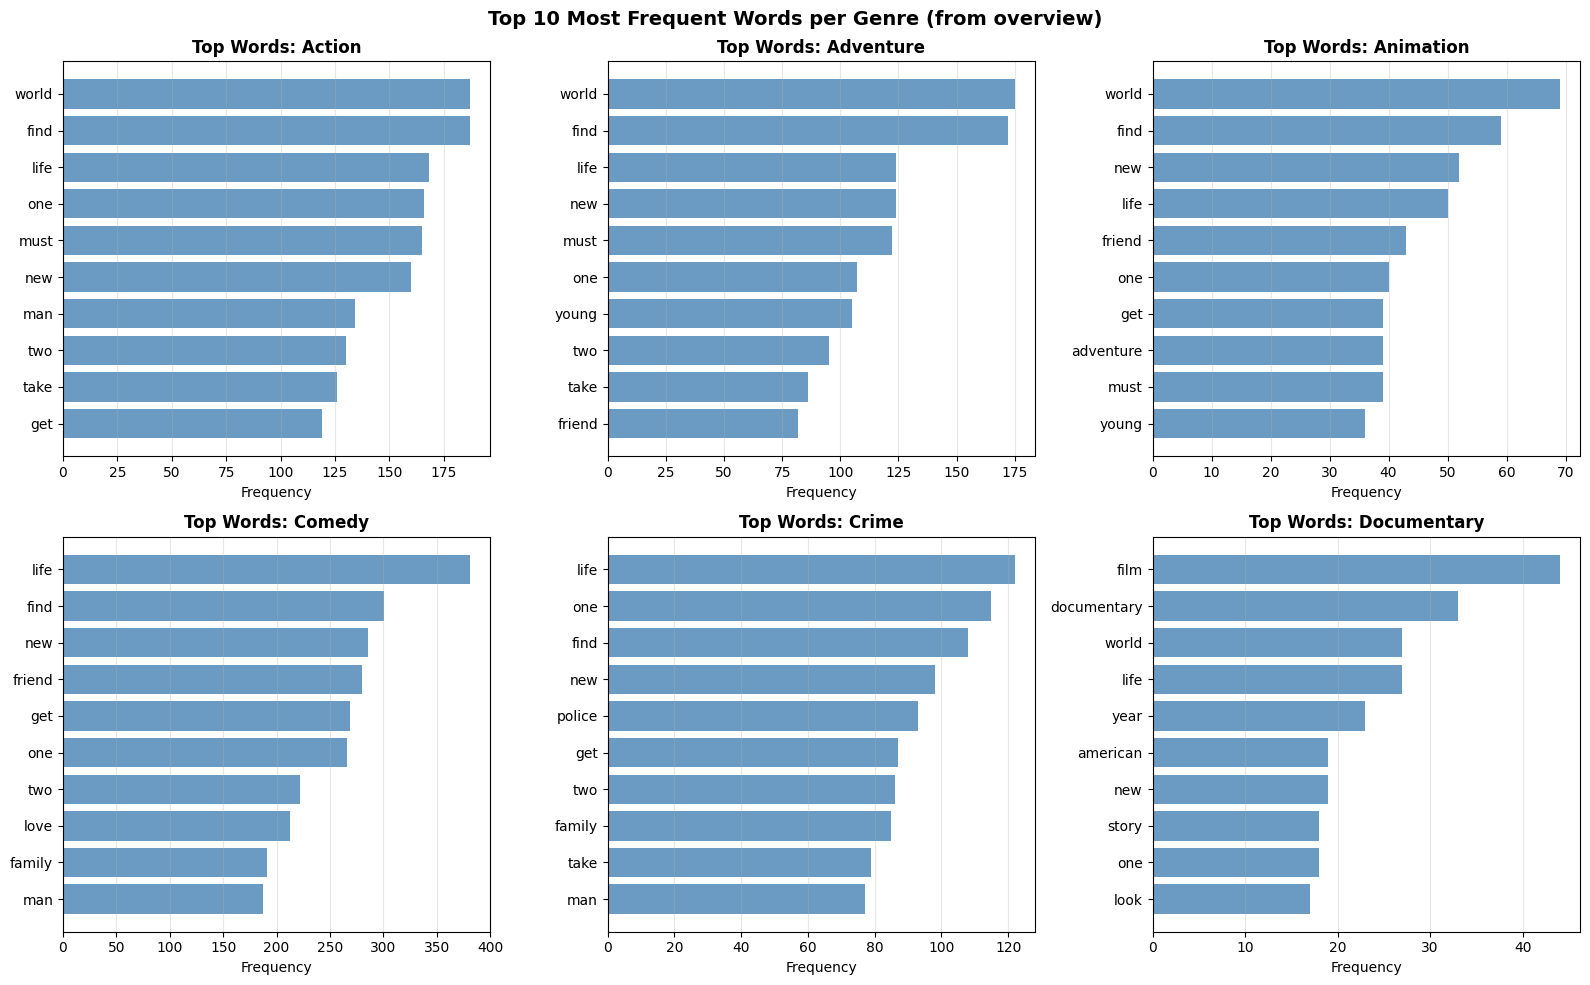

In [ ]:
genres_to_plot = [g for g in ALL_GENRES if genre_word_freq[g]][:6]
n = len(genres_to_plot)
fig, axes = plt.subplots(2, (n+1)//2, figsize=(16, 10))
axes = axes.flatten()

for i, genre in enumerate(genres_to_plot):
    top10 = genre_word_freq[genre].most_common(10)
    words, counts = zip(*top10) if top10 else ([], [])
    axes[i].barh(words[::-1], counts[::-1], color='steelblue', alpha=0.8)
    axes[i].set_title(f'Top Words: {genre}', fontweight='bold')
    axes[i].set_xlabel('Frequency')
    axes[i].grid(True, axis='x', alpha=0.3)

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle(f'Top 10 Most Frequent Words per Genre (from {ANALYSIS_COL})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('./genre_top_words.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
for genre in ALL_GENRES:
    counter = genre_word_freq[genre]
    if not counter:
        continue

    top10    = counter.most_common(10)
    above_threshold = {w: c for w, c in counter.items() if c >= 3}
    bottom10 = sorted(above_threshold.items(), key=lambda x: x[1])[:10]

    if not top10 or not bottom10:
        continue

    print(f"\n{'='*55}")
    print(f"  Genre: {genre.upper()}  ({df[genre].sum():.0f} movies)")
    print(f"{'='*55}")

    print(f"\n  Top 10 Most Frequent Words:")
    print(f"  {'Rank':<6} {'Word':<20} {'Count':>6}")
    print(f"  {'-'*34}")
    for i, (word, count) in enumerate(top10, 1):
        print(f"  {i:<6} {word:<20} {count:>6}")

    print(f"\n  Bottom 10 Least Frequent Words (≥ 3 occurrences):")
    print(f"  {'Rank':<6} {'Word':<20} {'Count':>6}")
    print(f"  {'-'*34}")
    for i, (word, count) in enumerate(bottom10, 1):
        print(f"  {i:<6} {word:<20} {count:>6}")

    top_words = [w for w, _ in top10[:5]]
    print(f"\n  Interpretation:")
    print(f"  The most frequent words {top_words} reflect the core")
    print(f"  themes and vocabulary typical of {genre} movies.")
    print(f"  Least frequent words appear rarely, suggesting they")
    print(f"  are specific to only a handful of {genre} films.")


  Genre: ACTION  (1153 movies)

  Top 10 Most Frequent Words:
  Rank   Word                  Count
  ----------------------------------
  1      world                   187
  2      find                    187
  3      life                    168
  4      one                     166
  5      must                    165
  6      new                     160
  7      man                     134
  8      two                     130
  9      take                    126
  10     get                     119

  Bottom 10 Least Frequent Words (≥ 3 occurrences):
  Rank   Word                  Count
  ----------------------------------
  1      believed                  3
  2      turner                    3
  3      spectre                   3
  4      modernday                 3
  5      sort                      3
  6      closest                   3
  7      vesper                    3
  8      pursuing                  3
  9      determination             3
  10     eternal                 

## Task 6: Genre-Indicative Words via TF-IDF + Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer as SklearnTFIDF

train_strings = [tokens_to_string(t) for t in train_df[f'{ANALYSIS_COL}_tokens'].tolist()]
val_strings   = [tokens_to_string(t) for t in val_df[f'{ANALYSIS_COL}_tokens'].tolist()]
test_strings  = [tokens_to_string(t) for t in test_df[f'{ANALYSIS_COL}_tokens'].tolist()]
all_strings   = [tokens_to_string(t) for t in df[f'{ANALYSIS_COL}_tokens'].tolist()]

tfidf_lr = SklearnTFIDF(max_features=10000, min_df=2)
X_tfidf_train = tfidf_lr.fit_transform(train_strings)
X_tfidf_test  = tfidf_lr.transform(test_strings)

feature_names = np.array(tfidf_lr.get_feature_names_out())
print(f"TF-IDF vocabulary size: {len(feature_names)}")
print(f"TF-IDF train matrix shape: {X_tfidf_train.shape}")

TF-IDF vocabulary size: 7872
TF-IDF train matrix shape: (3342, 7872)


In [ ]:
print("Training one Logistic Regression per genre...\n")
genre_indicators = {} 

for genre in ALL_GENRES:
    y_tr_genre = train_df[genre].values

    if y_tr_genre.sum() < 5:
        print(f"  Skipping {genre} (too few samples: {y_tr_genre.sum()})")
        continue

    lr_model = LogisticRegression(C=1.0, max_iter=1000, class_weight='balanced', solver='lbfgs')
    lr_model.fit(X_tfidf_train, y_tr_genre)

    coefs = lr_model.coef_[0]
    top_idx = np.argsort(coefs)[::-1][:10] 
    top_words = [(feature_names[i], coefs[i]) for i in top_idx]
    genre_indicators[genre] = top_words
    
print("\n" + "="*65)
print("Genre-Indicative Words (TF-IDF + Logistic Regression)")
print("="*65)

for genre, words in genre_indicators.items():
    print(f"\n{genre.upper()}:")
    for word, weight in words:
        print(f"  {word:<20} weight={weight:+.4f}")

Training one Logistic Regression per genre...


Genre-Indicative Words (TF-IDF + Logistic Regression)

ACTION:
  agent                weight=+3.0441
  cop                  weight=+2.6363
  warrior              weight=+2.1981
  fight                weight=+2.0040
  target               weight=+1.9106
  force                weight=+1.8464
  hero                 weight=+1.8300
  kidnapped            weight=+1.7870
  criminal             weight=+1.7804
  assassin             weight=+1.7739

ADVENTURE:
  adventure            weight=+3.6907
  world                weight=+2.1420
  power                weight=+2.1142
  bond                 weight=+2.0365
  warrior              weight=+1.9550
  save                 weight=+1.8608
  dinosaur             weight=+1.8537
  find                 weight=+1.8462
  mission              weight=+1.8289
  harry                weight=+1.7233

ANIMATION:
  human                weight=+3.1555
  adventure            weight=+3.0608
  animated             weight

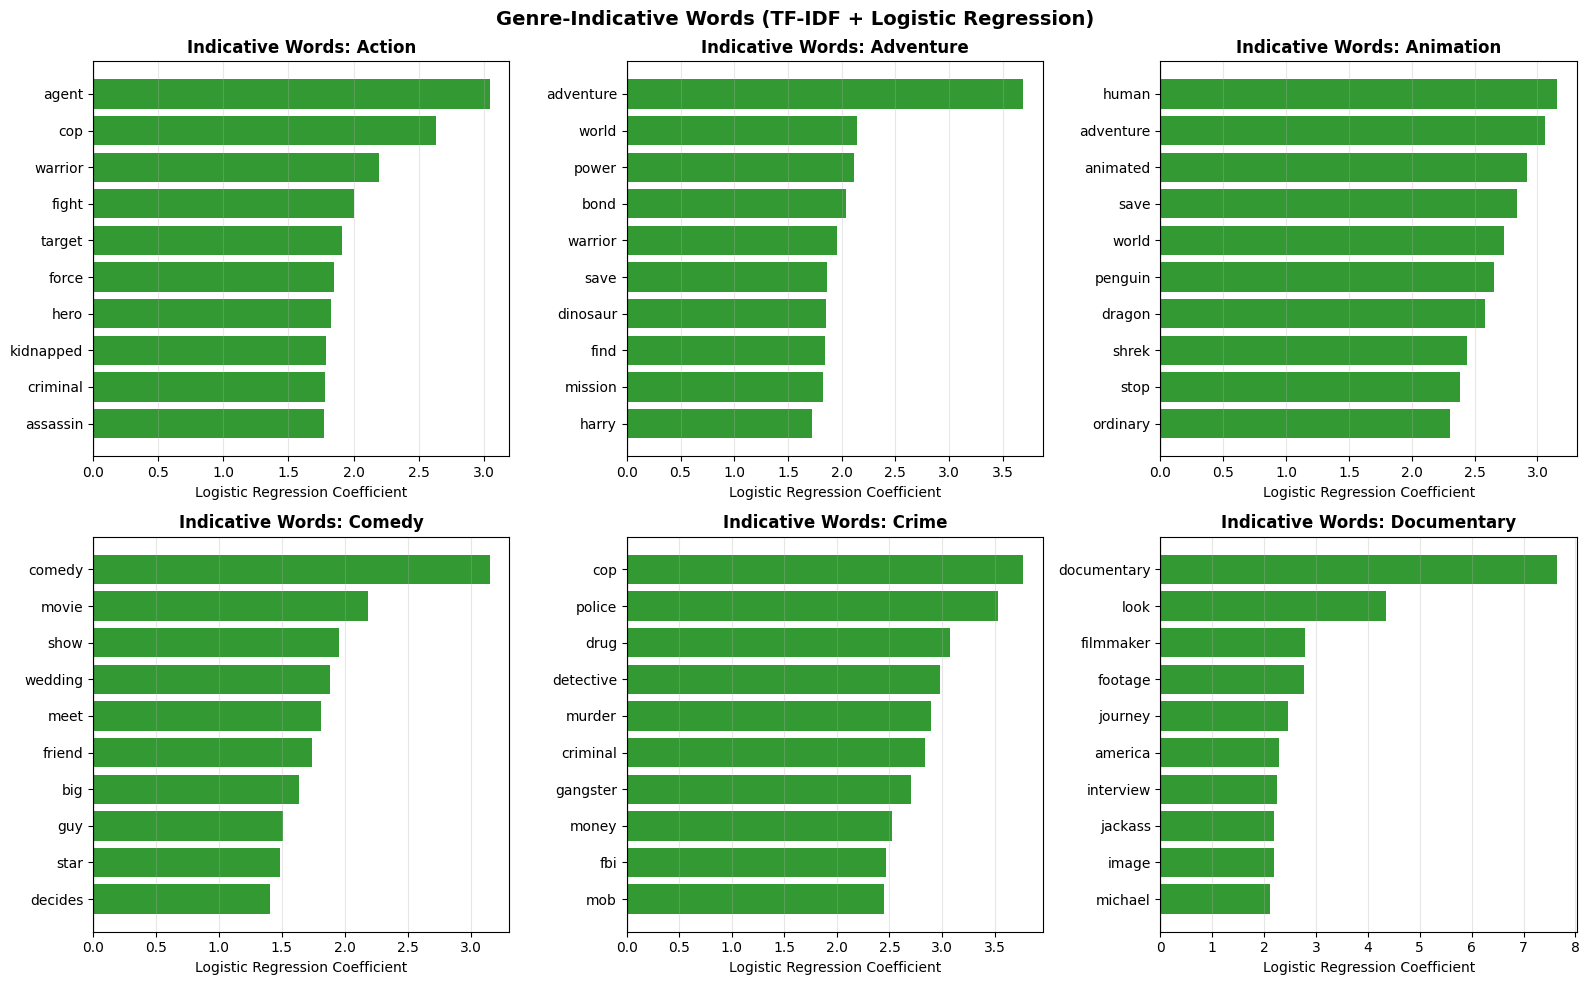


Interpretations:

Action: High-weight words likely include 'fight', 'weapon', 'chase', 'battle' — physical conflict language

Animation: Words like 'adventure', 'magic', 'young', 'friendship' indicate child-friendly narratives

Comedy: Words like 'laugh', 'funny', 'joke', 'awkward' suggest humor-related vocabulary


In [ ]:
genre_interpretations = {
    'Action':   "High-weight words likely include 'fight', 'weapon', 'chase', 'battle' — physical conflict language",
    'Comedy':   "Words like 'laugh', 'funny', 'joke', 'awkward' suggest humor-related vocabulary",
    'Drama':    "Words like 'family', 'struggle', 'emotional', 'relationship' reflect character-driven stories",
    'Horror':   "Words like 'terror', 'ghost', 'fear', 'kill' reflect the genre's dark vocabulary",
    'Romance':  "Words like 'love', 'heart', 'couple', 'fall' reveal relationship-focused themes",
    'Thriller': "Words like 'suspect', 'danger', 'escape', 'secret' reflect tension and mystery",
    'Sci-Fi':   "Words like 'planet', 'space', 'future', 'alien' reveal futuristic themes",
    'Animation':"Words like 'adventure', 'magic', 'young', 'friendship' indicate child-friendly narratives",
}

genres_with_data = list(genre_indicators.keys())[:6]
n = len(genres_with_data)
fig, axes = plt.subplots(2, (n+1)//2, figsize=(16, 10))
axes = axes.flatten()

for i, genre in enumerate(genres_with_data):
    words, weights = zip(*genre_indicators[genre]) if genre_indicators[genre] else ([], [])
    colors = ['green' if w > 0 else 'red' for w in weights]
    axes[i].barh(words[::-1], weights[::-1], color=colors[::-1], alpha=0.8)
    axes[i].axvline(0, color='black', linewidth=0.8)
    axes[i].set_title(f'Indicative Words: {genre}', fontweight='bold')
    axes[i].set_xlabel('Logistic Regression Coefficient')
    axes[i].grid(True, axis='x', alpha=0.3)

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Genre-Indicative Words (TF-IDF + Logistic Regression)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('./genre_indicative_words.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nInterpretations:")
for genre in genres_with_data:
    if genre in genre_interpretations:
        print(f"\n{genre}: {genre_interpretations[genre]}")

---
## Final Results Summary

Complete comparison of all experiments across different text inputs.

In [ ]:
print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)

print("\n[TASK 2] GloVe Embedding Info")
print(f"  GloVe Dimension: {GLOVE_DIM}D (100-dimensional)")
print(f"  GloVe Vocabulary: {len(glove_vectors):,} words")
print(f"  Document embedding: TF-IDF weighted averaging")

print("\n[TASK 3] Regression Results (Predict voting_average)")
print(f"  {'Model':<20} {'MSE':>10} {'RMSE':>10}")
print(f"  {'Baseline (mean)':<20} {baseline_mse:>10.4f} {baseline_rmse:>10.4f}")
for col, res in regression_results.items():
    print(f"  {'MLP+GloVe+'+col:<20} {res['mse']:>10.4f} {res['rmse']:>10.4f}")

print("\n[TASK 4] Classification Results (Predict genre)")
print(f"  {'Model':<20} {'Micro-F1':>10} {'Macro-F1':>10} {'Hamming':>10} {'Jaccard':>10}")
for col, res in classification_results.items():
    print(f"  {'MLP+GloVe+'+col:<20} {res['micro_f1']:>10.4f} {res['macro_f1']:>10.4f} {res['hamming']:>10.4f} {res['jaccard']:>10.4f}")

print("\n[TASK 5] Word Frequency Analysis")
print(f"  Text column analyzed: {ANALYSIS_COL}")
print(f"  Min frequency threshold for 'least frequent': {MIN_FREQ}")
print(f"  Results shown per genre above.")

print("\n[TASK 6] TF-IDF + LR Indicative Words")
print(f"  Genres analyzed: {list(genre_indicators.keys())}")
print(f"  Top 10 positive-weight words reported per genre above.")

print("\n" + "="*70)


FINAL RESULTS SUMMARY

[TASK 2] GloVe Embedding Info
  GloVe Dimension: 100D (100-dimensional)
  GloVe Vocabulary: 773,841 words
  Document embedding: TF-IDF weighted averaging

[TASK 3] Regression Results (Predict voting_average)
  Model                       MSE       RMSE
  Baseline (mean)          1.2322     1.1101
  MLP+GloVe+overview       1.2621     1.1234
  MLP+GloVe+tagline        1.3280     1.1524

[TASK 4] Classification Results (Predict genre)
  Model                  Micro-F1   Macro-F1    Hamming    Jaccard
  MLP+GloVe+overview       0.0000     0.0000     0.0009     0.0000
  MLP+GloVe+tagline        0.0000     0.0000     0.0009     0.0000

[TASK 5] Word Frequency Analysis
  Text column analyzed: overview
  Min frequency threshold for 'least frequent': 3
  Results shown per genre above.

[TASK 6] TF-IDF + LR Indicative Words
  Genres analyzed: ['Action', 'Action Adventure Comedy', 'Action Adventure Comedy Thriller', 'Action Adventure Drama', 'Action Adventure Drama Thrill